In [1]:
# 用PageRank挖掘希拉里邮件中的重要人物关系
#networkx中一个节点可以是任意hash对象（除了None对象），一条边也可以关联任意的对象
import pandas as pd
import networkx as nx
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
# 读取邮件
emails = pd.read_csv("./input/Emails.csv")
# 读取别名
file = pd.read_csv("./input/Aliases.csv")
#aliases:别名-人物id键值对
aliases = {}
for index, row in file.iterrows():
    aliases[row['Alias']] = row['PersonId']
# 读取人名
file = pd.read_csv("./input/Persons.csv")
#persons:人物id-姓名 键值对
persons = {}
for index, row in file.iterrows():
    persons[row['Id']] = row['Name']

In [3]:
# 邮件中存在别名的情况，因此需要统一人物名称，对别名进行转换        
def unify_name(name):
    # 别名统一小写
    name = str(name).lower()
    # 去掉, 和@后面的内容
    name = name.replace(",","").split("@")[0]
    # 别名转换，返回真实姓名（若存在）
    if name in aliases.keys():
        return persons[aliases[name]]
    return name

In [43]:
# 画网络图
def show_graph(graph):
    # 使用Spring Layout布局，类似中心放射状
    positions = nx.spring_layout(graph)
    # 设置网络图中的节点大小，大小与pagerank值相关，因为pagerank值很小所以需要*20000
    #筛选出有data的节点
    nodesize = [x['pagerank'] * 20000 for v,x in graph.nodes(data=True)]
    # 设置网络图中的边长度
    #筛选出有data的边
    edgesize = [e[2]['weight'] for e in graph.edges(data=True)]
    # 绘制节点
    nx.draw_networkx_nodes(graph, positions, node_size=nodesize, alpha=0.6)
    # 绘制边
    nx.draw_networkx_edges(graph, positions, edge_size=edgesize, alpha=0.2)
    # 绘制节点的label
    nx.draw_networkx_labels(graph, positions, font_size=10)
    # 输出希拉里邮件中的所有人物关系图
    plt.show()


In [5]:
# 将寄件人和收件人的别名进行规范化
emails.MetadataFrom = emails.MetadataFrom.apply(unify_name)
emails.MetadataTo = emails.MetadataTo.apply(unify_name)

In [19]:
# 设置边的权重等于发邮件的次数
#edges_weights_temp 结构：(from, to), weight
edges_weights_temp = defaultdict(list)
for row in zip(emails.MetadataFrom, emails.MetadataTo, emails.RawText):
    temp = (row[0], row[1])
    if temp not in edges_weights_temp:
        edges_weights_temp[temp] = 1
    else:
        edges_weights_temp[temp] = edges_weights_temp[temp] + 1
        
# 转化格式 (from, to), weight => from, to, weight
edges_weights = [(key[0], key[1], val) for key, val in edges_weights_temp.items()]

# 创建一个有向图
graph = nx.DiGraph()
# 设置有向图中的路径及权重(from, to, weight)
graph.add_weighted_edges_from(edges_weights)
# 计算每个节点（人）的PR值，并作为节点的pagerank属性
pagerank = nx.pagerank(graph)
# 获取每个节点的pagerank数值
pagerank_list = {node: rank for node, rank in pagerank.items()}
# 将pagerank数值作为节点的属性
nx.set_node_attributes(graph, name = 'pagerank', values = pagerank_list)
print(graph.edges(data = True))

[('Jake Sullivan', 'Hillary Clinton', {'weight': 815}), ('Jake Sullivan', 'Wendy Sherman', {'weight': 1}), ('Jake Sullivan', 'Cheryl Mills', {'weight': 4}), ('Jake Sullivan', 'Strobe Talbott', {'weight': 1}), ('Jake Sullivan', 'Philippe Reines', {'weight': 7}), ('Jake Sullivan', 'preines; h', {'weight': 1}), ('Jake Sullivan', 'Philip Crowley', {'weight': 1}), ('Jake Sullivan', 'Richard Verma', {'weight': 2}), ('Jake Sullivan', 'Huma Abedin', {'weight': 6}), ('Jake Sullivan', 'slaughter anne-marie', {'weight': 2}), ('Jake Sullivan', 'Jacob Lew', {'weight': 1}), ('Jake Sullivan', 'Judith McHale', {'weight': 2}), ('Jake Sullivan', 'Daniel Schwerin', {'weight': 1}), ('Jake Sullivan', 'aclb', {'weight': 1}), ('Hillary Clinton', 'Huma Abedin', {'weight': 32}), ('Hillary Clinton', 'russorv', {'weight': 26}), ('Hillary Clinton', 'sullivanjj', {'weight': 288}), ('Hillary Clinton', 'Oscar Flores', {'weight': 5}), ('Hillary Clinton', 'abedinh', {'weight': 345}), ('Hillary Clinton', 'millscd', {'w

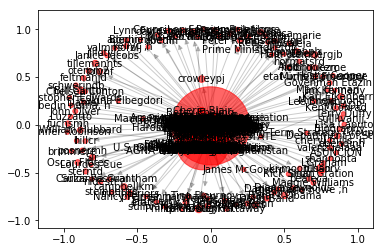

In [44]:
# 画网络图
show_graph(graph)

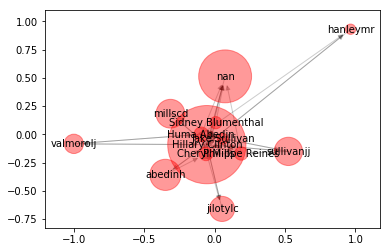

In [12]:
# 将完整的图谱进行精简
# 设置PR值的阈值，筛选大于阈值的重要核心节点
pagerank_threshold = 0.005
# 复制一份计算好的网络图
small_graph = graph.copy()
# 剪掉PR值小于pagerank_threshold的节点
for n, p_rank in graph.nodes(data=True):
    if p_rank['pagerank'] < pagerank_threshold: 
        small_graph.remove_node(n)
# 画网络图
show_graph(small_graph)